# Review: Complex Queries

* Restriction by a query (Subquery in the `WHERE` clause)
* Join
    - Cross join
    - Inner join
    - Equijoin
    - Natural join
* Aggregation  
    * `LEFT JOIN` followed by `GROUP BY`

# Relational Division

Relational division is a query of the type: 
> "Find all entries in A that have a mathcing entry in B for each entry in C."

For example, imagine you have a database for managing the hiring pipeline for a company. You have Tables `Candidate` and `CandidateSkill` listing all employees' skills. Then you have a table `Job` and `RequiredSkills`. 

You are now asked to
> "Show all the candidates who qualify for a given job."

Examples from other databases could be:
> "Find all students who have completed all the required courses for their major."
> "Find all students who have completed all the required courses for their major."
> "Show all airlins that every 

This is not a trivial query with no direct support in DataJoint and SQL. There are several ways to solve it. I will illustrate just one. You can search for other articles on relational division to review other approaches.

In [1]:
import datajoint as dj
from faker import Faker
fake = Faker()

In [2]:
schema = dj.Schema('dimitri_hiring')
schema.drop()
schema = dj.Schema('dimitri_hiring')

[2022-10-18 22:51:02,839][INFO]: Connecting dimitri@db.ust-data-sci.net:3306
[2022-10-18 22:51:03,774][INFO]: Connected dimitri@db.ust-data-sci.net:3306


Proceed to delete entire schema `dimitri_hiring`? [yes, No]: 


In [3]:
@schema
class Skill(dj.Lookup):
    definition = """
    skill : varchar(24)
    """
    contents = zip(("SQL", "Java", "Python", "C++", "JavaScript", "R", "Rust"))
    

In [4]:
@schema
class Candidate(dj.Manual):
    definition = """
    candidate_id : int
    ---
    name  : varchar(60)
    """
    
    class Skill(dj.Part):
        definition = """
        -> master
        -> Skill
        """

In [5]:
Candidate.insert(((fake.random_int(), fake.name()) for _ in range(300)), 
                 skip_duplicates=True)

In [6]:
Candidate.Skill.insert(
    Candidate.proj() * Skill & 'RAND() < 0.4')

In [7]:
Candidate.Skill()

candidate_id,skill
178,C++
178,Java
178,SQL
190,C++
190,SQL
225,JavaScript
225,R
281,Java
281,JavaScript
281,R


In [8]:
@schema
class Position(dj.Manual):
    definition = """
    position : varchar(12)   
    ---
    position_description : varchar(60)
    """

    class Skill(dj.Part):
        definition = """
        -> master
        -> Skill
        """

In [9]:
Position.insert1(("SWE1", "Software Engineer I"))
Position.Skill.insert((
    ("SWE1", "Rust"),
    ("SWE1", "JavaScript"),
    ("SWE1", "Java")))

In [10]:
Position.insert1(("DS2", "Data Scientist II"))
Position.Skill.insert((
    ("DS2", "SQL"),
    ("DS2", "Python")))

In [11]:
Position.Skill()

position,skill
DS2,Python
DS2,SQL
SWE1,Java
SWE1,JavaScript
SWE1,Rust


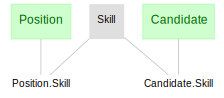

In [12]:
dj.Diagram(schema)

# Query example

In [13]:
# All candidates who have the required skill

cpp_experts = Candidate & (Candidate.Skill & {"skill": 'C++'})
cpp_experts

candidate_id,name
178,Bradley Chavez
190,Courtney Cox
335,Morgan Wells
336,Ashley Terry
404,Craig Mendoza
491,Sandra Frye
744,Mary Waters
806,Michael Rogers
817,Joseph Mcdonald
819,Terri Ray


### Show candidates who qualify for a given job

Rephrase (position)

> Show candidates who have *all* the skills required for job "SWE1"

Rephrasing (a double negative)

> Show candidates for whom there is no skill required for job "SWE1" that she does not possess.


In [14]:
# skills for SWE1
required_skill = Position.Skill() & {'position': "SWE1"}
required_skill

position,skill
SWE1,Java
SWE1,JavaScript
SWE1,Rust


In [15]:
# candidates' missing skills
missing_skill = Candidate.proj() * required_skill - Candidate.Skill
missing_skill

candidate_id,position,skill
178,SWE1,JavaScript
178,SWE1,Rust
190,SWE1,Java
190,SWE1,JavaScript
190,SWE1,Rust
225,SWE1,Java
225,SWE1,Rust
331,SWE1,JavaScript
331,SWE1,Rust
335,SWE1,JavaScript


In [18]:
# qualified candidates
qualified_candidate = Candidate - missing_skill
qualified_candidate

candidate_id,name
281,Bethany Carpenter
853,Dustin Ward
1342,Sara Miller
1397,Robin Brown
1938,Gina Duke
2429,Michelle Curry
2905,Robert Wang Jr.
3230,Vincent Bender
4278,Luis Kim
4980,Sarah Wilson


In [19]:
# Candidates who qualify for job SWE1

Candidate - (
    (Candidate.proj() * Position.Skill & {'position': "SWE1"})
    - Candidate.Skill)

candidate_id,name
281,Bethany Carpenter
853,Dustin Ward
1342,Sara Miller
1397,Robin Brown
1938,Gina Duke
2429,Michelle Curry
2905,Robert Wang Jr.
3230,Vincent Bender
4278,Luis Kim
4980,Sarah Wilson


## SQL equlvalent

Literal translation of the above DataJoint query
```sql
USE dimitri_hiring;

SELECT candidate_id, name 
FROM candidate 
WHERE candidate_id NOT IN (
    SELECT candidate_id
    FROM candidate NATURAL JOIN position__skill
    WHERE position = "SWE1" AND (candidate_id, skill) NOT IN (
        SELECT candidate_id, skill FROM candidate__skill))
```

## Using Aggregation

Another method is to simply compare the number of matching skils for each candidate to the total number of matching skills, using aggregation.

In [24]:
Candidate()

candidate_id,name
178,Bradley Chavez
190,Courtney Cox
225,David Cherry
281,Bethany Carpenter
331,Carl Johnson
335,Morgan Wells
336,Ashley Terry
404,Craig Mendoza
491,Sandra Frye
507,Donna Ramirez


In [23]:
Candidate.Skill() * Position.Skill() & {'position': 'SWE1'}

candidate_id,skill,position
178,Java,SWE1
281,Java,SWE1
331,Java,SWE1
335,Java,SWE1
336,Java,SWE1
621,Java,SWE1
744,Java,SWE1
819,Java,SWE1
823,Java,SWE1
853,Java,SWE1


In [27]:
qualified = Candidate.aggr(
    Candidate.Skill * Position.Skill & {'position': "SWE1"}, 
     n='count(skill)') & 'n=3'

qualified

candidate_id,n calculated attribute
281,3
853,3
1342,3
1397,3
1938,3
2429,3
2905,3
3230,3
4278,3
4980,3


## SQL equivalent

```sql
SELECT candidate_id, name 
FROM candidate NATURAL JOIN 
     candidate__skill NATURAL JOIN position__skill
WHERE position="SWE1" 
GROUP BY candidate_id 
HAVING n=3
```